# Mistral vs LLama 2 vs Gemma

### Import Libraries

In [1]:
from generator.generator import Generator
from datasets import load_dataset
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import utils


llama = Generator(model='llama')
mistral = Generator(model='mistral')
gemma = Generator(model='gemma')

/Users/rafael/miniconda3/envs/zaai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
llama_model_loader: loaded meta data with 22 key-value pairs and 291 tensors from /Users/rafael/Documents/lab/large-language-models/gemma/model/Meta-Llama-3-8B-Instruct-Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = ..
llama_model_loader: - kv   2:                           llama.vocab_size u32              = 128256
llama_model_loader: - kv   3:                       llama.context_length u32              = 8192
llama_model_loader: - kv   4:       

### Load Q&A Data 

In [2]:
squad = load_dataset("squad", split="train")
squad = squad.shuffle()

### Create dictionary to save metrics

In [3]:
llama_metrics = {
    "words_per_second": [],
    "words": [],
}

mistral_metrics = {
    "words_per_second": [],
    "words": [],
}

gemma_metrics = {
    "words_per_second": [],
    "words": [],
}

### Gather metrics

In [4]:
for i in range(30):
    context = squad[i]['context']
    query = squad[i]['question']
    answer = squad[i]['answers']['text'][0]

    # llama
    answer_llama, words_per_second, words = utils.get_llm_response(llama, context, query)
    llama_metrics["words_per_second"].append(words_per_second)
    llama_metrics["words"].append(words)

    # mistral
    answer_mistral, words_per_second, words = utils.get_llm_response(mistral, context, query)
    mistral_metrics["words_per_second"].append(words_per_second)
    mistral_metrics["words"].append(words)

    # gemma
    answer_gemma, words_per_second, words = utils.get_llm_response(gemma, context, query)
    gemma_metrics["words_per_second"].append(words_per_second)
    gemma_metrics["words"].append(words)
    

/Users/rafael/miniconda3/envs/zaai/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(

llama_print_timings:        load time =   11356.44 ms
llama_print_timings:      sample time =      55.82 ms /    42 runs   (    1.33 ms per token,   752.43 tokens per second)
llama_print_timings: prompt eval time =   60056.77 ms /   366 tokens (  164.09 ms per token,     6.09 tokens per second)
llama_print_timings:        eval time =   11165.54 ms /    41 runs   (  272.33 ms per token,     3.67 tokens per second)
llama_print_timings:       total time =   72205.35 ms /   407 tokens

llama_print_timings:        load time =   11236.46 ms
llama_print_timings:      sample time =       6.28 ms /    18 runs   (    0.35 ms per token,  2864.42 tokens per second)
llama_print_timings: prompt eval time =   68235.76 ms /   421 tokens (  162.08 ms 

### Metrics comparison

#### Mistral 7B vs Llama 2 7B vs Gemma 7B

In [10]:
mistral_metrics = pd.DataFrame(mistral_metrics)
mistral_metrics['model'] = 'Mistral 7B'
llama_metrics = pd.DataFrame(llama_metrics)
llama_metrics['model'] = 'Llama 3 8B'
gemma_metrics = pd.DataFrame(gemma_metrics)
gemma_metrics['model'] = 'Gemma 7B'

# create single data frame for plotting
metrics = pd.concat([mistral_metrics, llama_metrics, gemma_metrics])

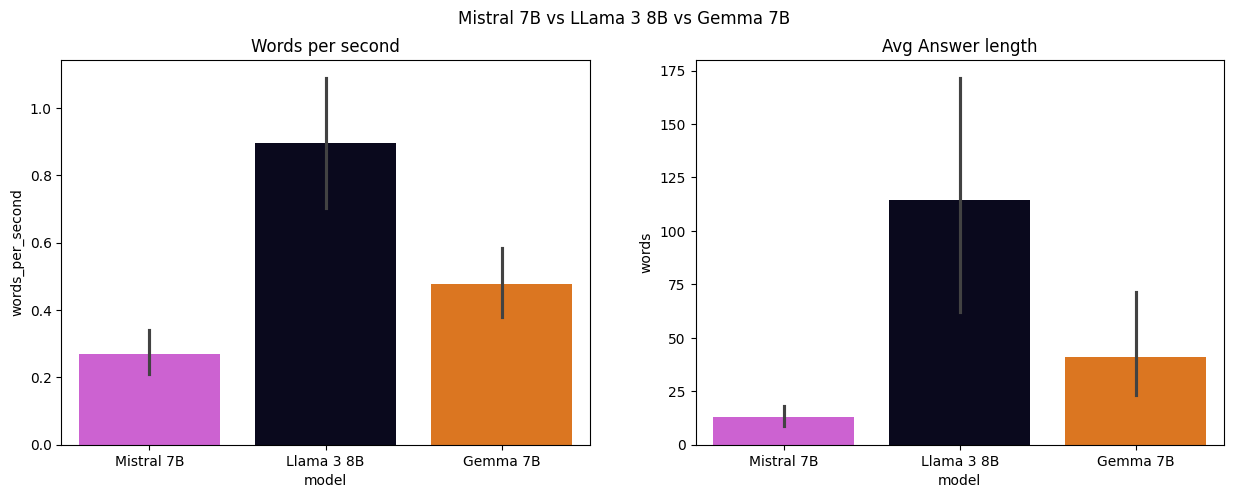

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Mistral 7B vs LLama 3 8B vs Gemma 7B')

sns.barplot(ax=axes[0], data=metrics, y='words_per_second', x='model', hue='model', palette=["#dd4fe4", "#070620", "#fa7302"])
axes[0].set_title("Words per second")

sns.barplot(ax=axes[1], data=metrics, y='words', x='model', hue='model', palette=["#dd4fe4", "#070620", "#fa7302"])
axes[1].set_title("Avg Answer length")

plt.show()